In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tableone import TableOne
random_seed = 42 # do not change

## additional imports
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.utils import resample
from sklearn.base import clone
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler


### Load and Process Original dataset - 2015

In [2]:
data = pd.read_csv("dataset_2015.csv")
data.shape


(278726, 81)

#### computing propensity score and trimming the data with scores out the range [0.05-0.95]

In [3]:
# Define treatment and outcome
T = data['computer']  # Binary treatment: 1 = has computer, 0 = no
y = data['achievement']       # Outcome: average score of math, read, and science

# Define confounders (exclude country, T, and Y)
excluded_cols = ['achievement', 'computer','internet']  # internet is a mediator
confounders = [col for col in data.columns if col not in excluded_cols]
X = data[confounders]

In [4]:
# Train-validation split
X_train, X_val, T_train, T_val, y_train, y_val = train_test_split(X, T, y, test_size=0.3, random_state=42)


In [5]:
# Train function
def train_propensity_model(model, X_train, T_train):
    return model.fit(X_train, T_train)

# Evaluation function
def eval_propensity_model(fitted_model, X_val, T_val):
    model_name = fitted_model.__class__.__name__
    T_probs = fitted_model.predict_proba(X_val)[:, 1]
    brier = brier_score_loss(T_val, T_probs)
    print("*" * 100)
    print(f"{model_name} - Brier Score: {brier:.4f}")
    prob_true, prob_pred = calibration_curve(T_val, T_probs, n_bins=10)
    plt.figure(figsize=(6, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Proportion Treated')
    plt.title(f'Calibration Curve - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()


In [6]:
# Overlap checking function
def check_overlap(propensity_model, X_train, T_train):
    propensity_scores = propensity_model.predict_proba(X_train)[:, 1]
    treated_scores = propensity_scores[T_train == 1]
    control_scores = propensity_scores[T_train == 0]
    overlap_lower = max(treated_scores.min(), control_scores.min())
    overlap_upper = min(treated_scores.max(), control_scores.max())
    plt.figure(figsize=(8, 6))
    sns.histplot(treated_scores, bins=30, color='blue', label='Treated (T=1)',stat='density',  alpha=0.5)
    sns.histplot(control_scores, bins=30, color='red', label='Control (T=0)',stat='density', alpha=0.5)
    plt.axvline(x=overlap_lower, color='black', linestyle='--', label=f'Overlap Start ({overlap_lower:.2f})')
    plt.axvline(x=overlap_upper, color='black', linestyle='--', label=f'Overlap End ({overlap_upper:.2f})')
    plt.xlabel('Propensity Score')
    plt.ylabel('Density')
    plt.title('Propensity Score Distribution by Treatment Group')
    plt.legend()
    plt.grid(True)
    plt.show()

****************************************************************************************************
LogisticRegression - Brier Score: 0.1308


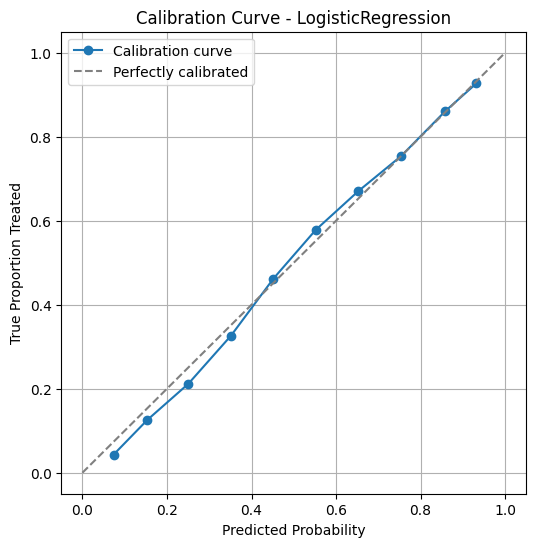

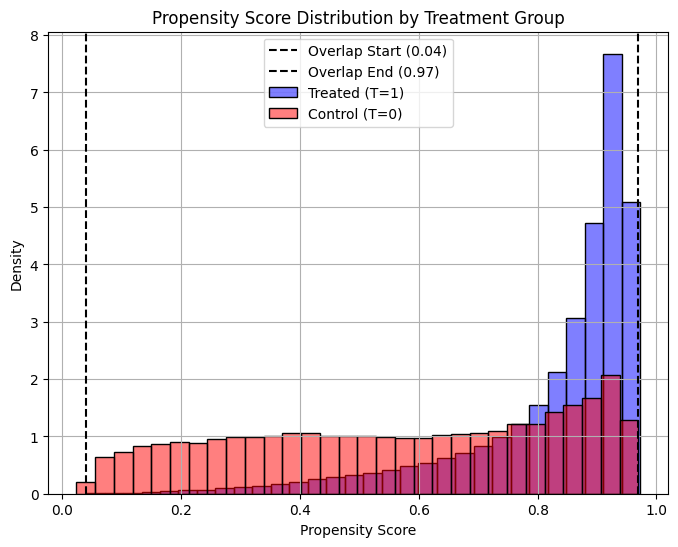

In [7]:
# Define and train models
lg_model = LogisticRegression(max_iter=10000, random_state=42)
propensity_model_lg = train_propensity_model(lg_model, X_train, T_train)
eval_propensity_model(propensity_model_lg, X_val, T_val)
check_overlap(propensity_model_lg, X_train, T_train)

In [8]:
# 1. Predict propensity scores on the full dataset
full_propensity_scores = propensity_model_lg.predict_proba(X)[:, 1]

# 2. Define bounds
lower_bound = 0.05
upper_bound = 0.95

# 3. Identify indices to keep (within overlap region)
mask = (full_propensity_scores >= lower_bound) & (full_propensity_scores <= upper_bound)

# 4. Trim the data accordingly
X_trimmed = X[mask]
T_trimmed = T[mask]
y_trimmed = y[mask]
propensity_scores_trimmed = full_propensity_scores[mask]

print(f"Original sample size: {X.shape[0]}")
print(f"Trimmed sample size: {X_trimmed.shape[0]}")


trimmed_data = pd.concat([X_trimmed, T_trimmed, y_trimmed], axis=1)
trimmed_data.to_csv("dataset_2015.csv", index=False)


Original sample size: 278726
Trimmed sample size: 262837


## Estimation

In [9]:
data = pd.read_csv("dataset_2015.csv")
data.shape

(262837, 81)

In [10]:
# Define treatment and outcome
T = data['computer']  # Binary treatment: 1 = has computer, 0 = no
y = data['achievement']      # Outcome: average score of math, read, and science

# Define confounders (exclude country, T, and Y)
excluded_cols = ['achievement', 'computer']  # internet is a mediator
confounders = [col for col in data.columns if col not in excluded_cols]
X = data[confounders]

In [11]:
# Train-validation split
X_train, X_val, T_train, T_val, y_train, y_val = train_test_split(X, T, y, test_size=0.3, random_state=42)

### T-Learner

In [12]:
def train_t_learner(model, X_train, y_train):
    """
    Return a fitted s-learner model on your training data
    :param model:
    :param X_train:
    :param y_train:
    :return:
    """
    return model.fit(X_train, y_train)

def t_learner_model_selection(models, metric, X_train, y_train, X_val, y_val,maximize=False):
    """
    Use the validation set to select the model with the best performance over the provided metric (e.g. rmse)
    Note that X_train and y_train should only include the appropriate intervention arm's data.

    You may select models in a more complicated way (like you would in real life). But here you can simplify.
    You must either return the fitted model or show the scores that lead to your decision.
    :param models:
    :param metric:
    :param X_train:
    :param y_train:
    :param X_val:
    :param y_val:
    :param maximize: Whether to maximize or minimize the metric
    :return:
    """
    scores = {}
    fitted_models = {}


    for name, model in models.items():
        fitted_model = train_t_learner(model, X_train, y_train)
        preds = fitted_model.predict(X_val)
        score = metric(y_val, preds)
        scores[name] = score
        fitted_models[name] = fitted_model
        print(f"{name} - Score: {score:.4f}")

    # Select based on direction
    best_model_name = max(scores, key=scores.get) if maximize else min(scores, key=scores.get)
    print(f"\nBest Model: {best_model_name} (Score: {scores[best_model_name]:.4f})")

    return fitted_models[best_model_name]

In [13]:
models = {
    'LinearRegression': LinearRegression(),
}

metrics = {
    'R2': r2_score,
}

In [14]:
fitted_t_learner_1 = None
fitted_t_learner_0 = None

for name, metric in metrics.items():
    print(f"\nMetric: {name}")
    maximize = True if name == "R2" else False  # Set according to metric
    # For T=1
    print("\n" + "="*40)
    print("T-Learner Model Selection for Treatment Group: T=1")
    print("="*40)

    X_train_1 = X_train.loc[T_train == 1]
    y_train_1 = y_train.loc[T_train == 1]
    X_val_1 = X_val.loc[T_val == 1]
    y_val_1 = y_val.loc[T_val == 1]

    fitted_t_learner_1 = t_learner_model_selection(
        models,
        metric,
        X_train_1,
        y_train_1,
        X_val_1,
        y_val_1,
        maximize=maximize
    )

    # For T=0
    print("\n" + "="*40)
    print("T-Learner Model Selection for Control Group: T=0")
    print("="*40)

    X_train_0 = X_train.loc[T_train == 0]
    y_train_0 = y_train.loc[T_train == 0]
    X_val_0 = X_val.loc[T_val == 0]
    y_val_0 = y_val.loc[T_val == 0]

    fitted_t_learner_0 = t_learner_model_selection(
        models,
        metric,
        X_train_0,
        y_train_0,
        X_val_0,
        y_val_0,
        maximize=maximize
    )
    print("\n" + "="*80)


Metric: R2

T-Learner Model Selection for Treatment Group: T=1
LinearRegression - Score: 0.3102

Best Model: LinearRegression (Score: 0.3102)

T-Learner Model Selection for Control Group: T=0
LinearRegression - Score: 0.3430

Best Model: LinearRegression (Score: 0.3430)



### Doubly Robust

In [15]:
def calculate_doubly_robust_ate(propensity_model, outcome_model_t1, outcome_model_t0, X, T, y):
    """
    Estimate ATE using the doubly robust estimator.
    """
    e = propensity_model.predict_proba(X)[:, 1]
    e = np.clip(e, 1e-3, 1 - 1e-3)

    mu1 = outcome_model_t1.predict(X)
    mu0 = outcome_model_t0.predict(X)

    T = np.array(T)
    y = np.array(y)

    term1 = T * (y - mu1) / e
    term2 = (1 - T) * (y - mu0) / (1 - e)
    ate_dr = np.mean(term1 - term2 + (mu1 - mu0))

    return ate_dr


In [16]:
ate_dr = calculate_doubly_robust_ate(propensity_model_lg, fitted_t_learner_1, fitted_t_learner_0, X_val, T_val, y_val)
print(f"Estimated ATE (Doubly Robust): {ate_dr:.4f}")

Estimated ATE (Doubly Robust): 25.8085


In [17]:
def doubly_robust_confidence_intervals(propensity_model, outcome_model_t1, outcome_model_t0,
                            X, T, y, n_bootstrap=1000, alpha=0.05, random_seed=42):
    """
    Bootstrap-based confidence intervals for the DR estimator.
    """
    np.random.seed(random_seed)
    dr_ate_estimates = []

    for _ in tqdm(range(n_bootstrap), desc="Bootstrapping DR ATE"):
        X_b, T_b, y_b = resample(X, T, y)
        try:
            ate = calculate_doubly_robust_ate(propensity_model, outcome_model_t1, outcome_model_t0, X_b, T_b, y_b)
            dr_ate_estimates.append(ate)
        except Exception:
            continue

    lower = np.percentile(dr_ate_estimates, 100 * alpha / 2)
    upper = np.percentile(dr_ate_estimates, 100 * (1 - alpha / 2))

    print(f"95% Confidence Interval for DR ATE: [{lower:.4f}, {upper:.4f}]")
    return lower, upper, dr_ate_estimates


In [18]:
lower, upper, dr_ates = doubly_robust_confidence_intervals(propensity_model_lg, fitted_t_learner_1, fitted_t_learner_0,
                                                X_val, T_val, y_val)

Bootstrapping DR ATE: 100%|██████████| 1000/1000 [02:41<00:00,  6.19it/s]

95% Confidence Interval for DR ATE: [24.1391, 27.4634]


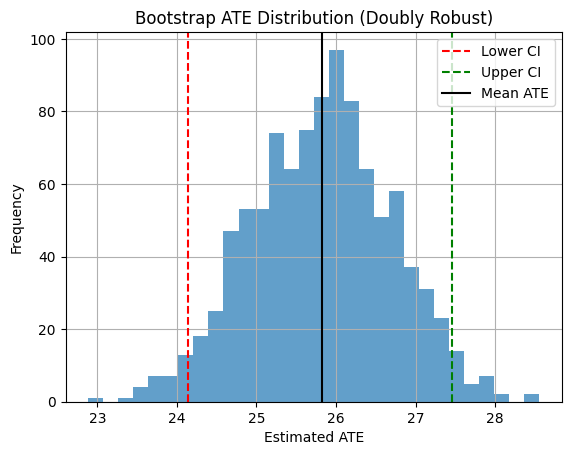

In [19]:
plt.hist(dr_ates, bins=30, alpha=0.7)
plt.axvline(lower, color='red', linestyle='--', label='Lower CI')
plt.axvline(upper, color='green', linestyle='--', label='Upper CI')
plt.axvline(np.mean(dr_ates), color='black', label='Mean ATE')
plt.title("Bootstrap ATE Distribution (Doubly Robust)")
plt.xlabel("Estimated ATE")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()